### In this document, we aim to find out what is importance of each input. We often use 5 inputs, GPA, GRE Total, Work Experience, TOEFL/IELTS and Research Papers. However, we are trying to understand and rank which inputs are most to least significant. 
### We needed this to create a feature in our app that would help in recommending schools to the user. 
### We found that we could use the Random Forest Model and tap on its Permutaion Importance and Feature Importance properties

In [1]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

import pandas as pd
data_path = '/Users/nathanyap/Desktop/DataMining_Project/project/Nathan Findings/TOEFL_IELTS_Combined.csv'
df_admitsFYI = pd.read_csv(data_path)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# we declare the dependent and independent variables
X = df_admitsFYI[['GPA', 'GRE Total', 'TOEFL/IELTS', 'Work Exp', 'Papers']]
y = df_admitsFYI['Status']

# a bit of cleaning
X = X.fillna(X.mean())

# advised to scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# usual split of the data with 70% for training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# to start and traing the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# working on the predictions
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# extracting the importances
feature_importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

# accuracy_rf, feature_importances


# Interestingly, TOEFL matters, we had the assumption that english scores would not necessarily
# be something of importance since it just qualifies someone to speak english
feature_importances




,Importance
GPA,0.490204
GRE Total,0.206450
TOEFL/IELTS,0.186049
Work Exp,0.093192
Papers,0.024105


### Directly below, we plotted the MDI graph
### First, to explain what is MDI, MDI stands for "Mean Decrease in Impurity". MDI is not calculated based directly from a simple formula, instead it is derived from the construction process of the Random Forest. Since a Random Forest is composed of many decision trees, everytime we split at a tree, the algorithm selects the feature that results in the largest decrease in impurity. At each tree, the decrease in impurity attributed by each feature can be calcualted. The more a feature decreases the impurity, the more important that feature is. 
### With that being said, MDI has its limitations too. Since the purity is assessed at every split of the tree, this shows that MDI is biased towards high cardinality. The reason for this is because if a category has a unqiue value at every split, this would lead to a substantial decrease in purity at every split and therefore resulting in a false sense of purity. Even if in actuality, that split does not have much predictive power for the new data.
### For this reason we will apply the Permutation Importance that you can see right below this analysis.

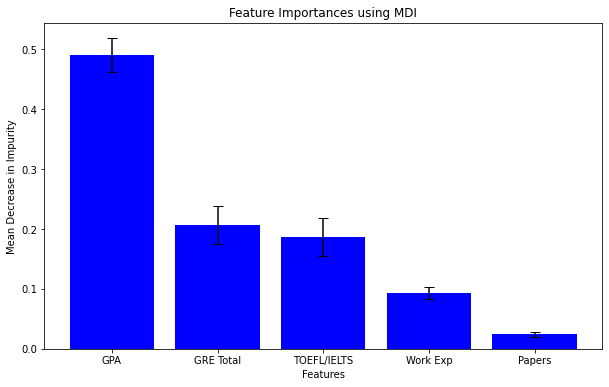

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

std_devs = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# generating the MDI graph
plt.figure(figsize=(10, 6))
bar = plt.bar(X.columns, feature_importances['Importance'], yerr=std_devs, color='blue', capsize=5)

# labeling
plt.title('Feature Importances using MDI')
plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')

# display
plt.show()

### Permutation importances is something we used to determing whether there are high cardinality by computing on a held out test set. This would see if there are any high cardinality because the measure for permutation importances is how the accuracy decreases 
### As we can see here the mean decreases corresponds to the rank of importance except for GRE scores but we know that GPA and GRE are still probably the best features in calculating the admission chances of a student. As such, based on this analysis, we continue with the 5 features as already ranked.

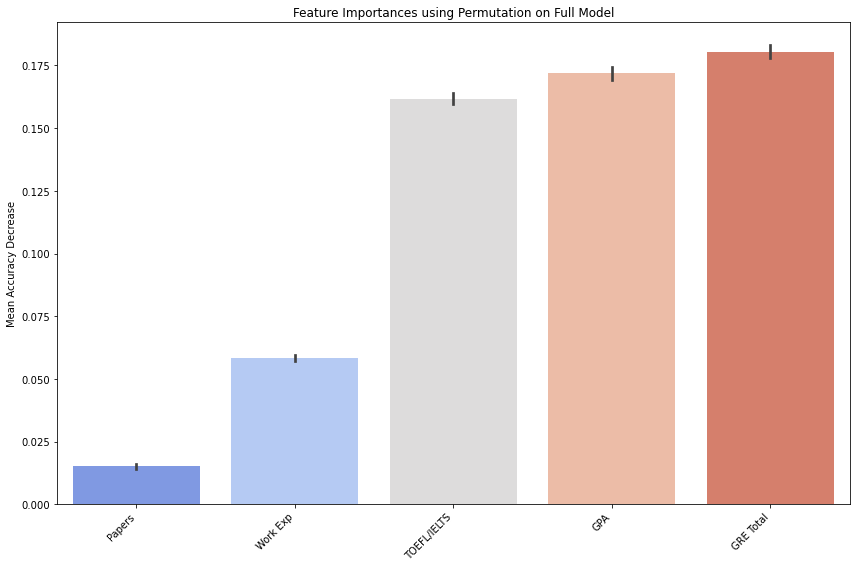

In [7]:
from sklearn.inspection import permutation_importance

# Performing permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Organizing the results
perm_importance_sorted_idx = perm_importance.importances_mean.argsort()
perm_importance_df = pd.DataFrame(perm_importance.importances[perm_importance_sorted_idx].T,
                                  columns=X.columns[perm_importance_sorted_idx])

# Plotting permutation feature importances with feature names on the x-axis
plt.figure(figsize=(12, 8))
perm_importance_barplot = sns.barplot(data=perm_importance_df, orient="v", palette="coolwarm")
perm_importance_barplot.set_title('Feature Importances using Permutation on Full Model')
perm_importance_barplot.set_ylabel('Mean Accuracy Decrease')
perm_importance_barplot.set_xticklabels(perm_importance_barplot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.tight_layout()
plt.show()